In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [13]:
class consts:
    pi = 3.141592
    c = 3e8
    e = 1.6e-19

    hbar = 6.58 * 10**-16   # eV * s
    h = hbar * 2 * pi
class setup:
    dummy = 0

    

### Calibration

In [14]:
calibration = pd.read_csv('data/calibration.txt', engine='python', sep=r'\s+', skiprows=3, header=None)
fmt = {
    0 : 'lambda',
    1 : 'pixel',
    2 : 'd_pixel',
}

calibration = mipt.map_excel(calibration, fmt)
calibration

,lambda,pixel,d_pixel
0,4339.235,97.000000,3.00000
1,4347.496,118.000000,4.00000
2,4358.350,146.000000,22.00000
3,4916.036,1206.000000,2.00000
4,4960.320,1269.000000,3.00000
5,5025.640,1361.000000,2.00000
6,5045.820,1388.000000,5.00000
7,5316.690,1714.000000,2.70000
8,5354.050,1757.000000,3.30000
9,5365.060,1767.540000,3.50000


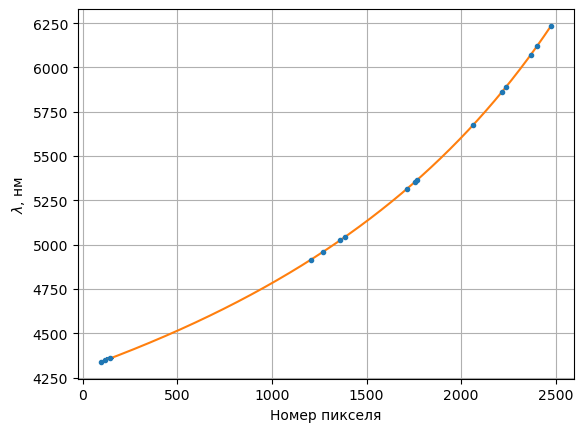

In [15]:
mipt.plot(calibration['pixel'], calibration['lambda'], func=None, xerr=calibration['d_pixel'])

x = np.arange(min(calibration['pixel']), max(calibration['pixel']))
approx = lambda pixel: 2443.42 + (-9.01305e+06) / (pixel - 4851.66)

plt.plot(x, approx(x))

plt.xlabel(r'Номер пикселя')
plt.ylabel(r'$\lambda$, нм')
plt.grid()
plt.savefig('gen/calibration.pdf')

In [16]:
d = calibration.dropna()
display(d)
fmt = {
    'lambda' : [r'$\lambda$, нм', '{:.1f}'],
    'pixel' : [r'Пиксель', '{:.1f}'],
    'd_pixel' : [r'Погрешность пикселя', '{:.1f}']
}

table = mipt.table(d, fmt)
table.to_latex('gen/calibration.tex')

,lambda,pixel,d_pixel
0,4339.235,97.000000,3.00000
1,4347.496,118.000000,4.00000
2,4358.350,146.000000,22.00000
3,4916.036,1206.000000,2.00000
4,4960.320,1269.000000,3.00000
5,5025.640,1361.000000,2.00000
6,5045.820,1388.000000,5.00000
7,5316.690,1714.000000,2.70000
8,5354.050,1757.000000,3.30000
9,5365.060,1767.540000,3.50000


In [17]:
series0 = pd.read_csv('data/series0.txt', delim_whitespace=True, header=None)
series1 = pd.read_csv('data/series1.txt', delim_whitespace=True, header=None)
series2 = pd.read_csv('data/series2.txt', delim_whitespace=True, header=None)

series1

,0,1
0,5429.496913,0.988577
1,5451.245606,1.812391
2,5473.982876,1.977154
3,5497.708723,1.977154
4,5522.258383,2.141917
5,5546.972807,1.977154
6,5573.005333,1.812391
7,5600.026437,1.977154
8,5627.706591,1.812391
9,5656.210560,1.977154


In [18]:
fmt = {
    0 : 'lambda',
    1 : 'd_lambda',
}

series0 = mipt.map_excel(series0, fmt)
series1 = mipt.map_excel(series1, fmt)
series2 = mipt.map_excel(series2, fmt)
series1

,lambda,d_lambda
0,5429.496913,0.988577
1,5451.245606,1.812391
2,5473.982876,1.977154
3,5497.708723,1.977154
4,5522.258383,2.141917
5,5546.972807,1.977154
6,5573.005333,1.812391
7,5600.026437,1.977154
8,5627.706591,1.812391
9,5656.210560,1.977154


,$\overline{x}$,$S_x$,$\overline{y}$,$S_y$,$R_{xy}$,$a$,$\Delta a$,$b$,$\Delta b$
0,6.0,14.0,5.364073e+14,1.024601e+26,3.785010e+13,2.703578e+12,2.898711e+10,5.201858e+14,2.049698e+11
1,6.0,14.0,5.300040e+14,1.032962e+26,3.800714e+13,2.714796e+12,2.727875e+10,5.137152e+14,1.928899e+11
2,5.0,10.0,5.125047e+14,8.816322e+25,2.968320e+13,2.968320e+12,2.448659e+10,4.976631e+14,1.448646e+11


a = (2.8e+12 +- 1.7e+11) Hz
h nu_2 = (0.012 +- 0.00071) eV
db = [6.47055664e+12 1.60521764e+13] Hz
h nu_1: [0.02675145 0.06636508] eV
h nu_1 = (0.047 +- 0.02) eV
dE = (2.17 +- 0.0111) eV


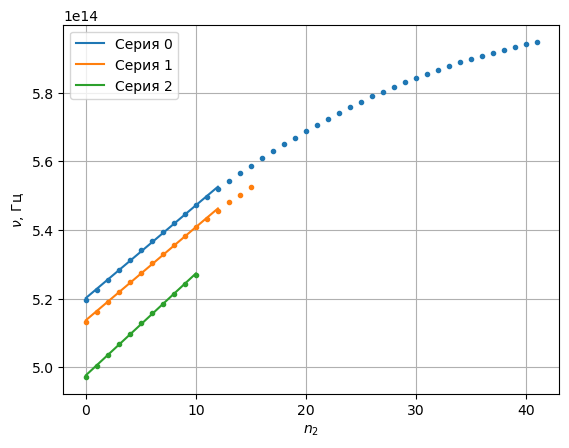

In [19]:
mnk = []
a = []
b = []
b_err = []
def plot(label, series, begin = 0, end = None):
    series = series.sort_values('lambda', ignore_index=True, ascending=False)
    x = np.array(range(len(series)))
    y = consts.c / (series['lambda']/1e10)
    yerr = series['d_lambda'] / series['lambda'] * y
    x, y, _ = mipt.plot(x, y, yerr=yerr, begin=begin, end=end, x_min=0, label=label)

    dat = mipt.mnk(x, y).data
    mnk.append(dat)
    a.append(dat['a'][0])
    b.append(dat['b'][0])
    b_err.append(dat['db'][0])

plot("Серия 0", series0, end=12)
plot("Серия 1", series1, end=12)
plot("Серия 2", series2)

plt.xlabel(r'$n_2$')
plt.ylabel(r'$\nu$, Гц')
plt.grid(True)
plt.legend()
plt.savefig('gen/series.pdf')

# Print least square approximation
fmt = {
    '<x>' : [r'$\overline{x}$', '{:.2f}'],
    'sx' : [r'$S_x$', '{:.2f}'],
    '<y>' : [r'$\overline{y}$', '{:.2e}'],
    'sy' : [r'$S_y$', '{:.2e}'],
    'rxy' : [r'$R_{xy}$', '{:.2e}'],
    'a' : [r'$a$', '{:.2e}'],
    'da' : [r'$\Delta a$', '{:.2e}'],
    'b' : [r'$b$', '{:.2e}'],
    'db' : [r'$\Delta b$', '{:.2e}'],
}

mnk = pd.concat(mnk, ignore_index=True)
table = mipt.table(mnk, fmt)
table.to_latex('gen/mnk.tex', na_rep='')
display(table.rename().get_data())

# Evaluate h nu_2
a_mean = np.mean(a)
a_dev = np.max([np.abs(a_mean - max(a)), np.abs(a_mean - min(a))])
print(f'a = ({a_mean:.2g} +- {a_dev:.2g}) Hz')
hnu2 = a_mean * consts.h
hnu2_err = a_dev * consts.h
print(f'h nu_2 = ({hnu2:.2g} +- {hnu2_err:.2g}) eV')

# Evnaluate h nu_1
db = np.array([b[0] - b[1], b[1] - b[2]])
print(f'db = {db} Hz')
print(f'h nu_1: {db * consts.h} eV')
hnu1 = np.mean(db) * consts.h
hnu1_err = consts.h * np.max([np.abs(np.mean(db) - max(db)), np.abs(np.mean(db) - min(db))])
print(f'h nu_1 = ({hnu1:.2g} +- {hnu1_err:.2g}) eV')

# Evaluate dE
dE = b[0] * consts.h - 1/2 * (hnu2 - hnu1)
dE_err = consts.h * np.abs(b_err[0]) + 1/2 * (hnu1_err + hnu2_err)
print(f'dE = ({dE:.3g} +- {dE_err:.3g}) eV')

In [20]:
keys = [ 'Серия 0', 'Серия 1', 'Серия 2']
data = pd.concat([series0, series1, series2], axis=1, keys=keys)
# display(data)

fmt = {
    (ser, 'lambda') : [r'$\lambda$, нм', '{:.1f}'] for ser in keys
}
fmt2 = {
    (ser, 'd_lambda') : [r'$\Delta \lambda$, нм', '{:.1f}'] for ser in keys
}
fmt.update(fmt2)

table = mipt.table(data, fmt)
table.to_latex('gen/series.tex', na_rep='')
table.rename().get_data()

Серия 0                            Серия 1                       \
   $\lambda$, нм $\Delta \lambda$, нм $\lambda$, нм $\Delta \lambda$, нм   
0    5773.880653             0.883511   5429.496913             0.988577   
1    5740.969886             1.325266   5451.245606             1.812391   
2    5708.440375             1.318103   5473.982876             1.977154   
3    5677.629727             1.153340   5497.708723             1.977154   
4    5646.819079             1.977154   5522.258383             2.141917   
5    5616.832245             2.306680   5546.972807             1.977154   
6    5588.657802             2.636205   5573.005333             1.812391   
7    5560.648122             2.636205   5600.026437             1.977154   
8    5533.956544             2.471442   5627.706591             1.812391   
9    5507.759255             2.306680   5656.210560             1.977154   
10   5482.715306             2.306680   5686.032631             2.471442   
11   5458.659933             2.636205   5716.019465             2.471442   
12   5434.934086             2.636205   5747.159639             1.977154   
13   5412.032054             2.965731   5779.617915             1.482865   
14   5389.953835             2.306680   5812.076192             1.482865   
15   5368.534668             2.306680   5846.676385             1.153340   
16   5348.104078             1.977154           NaN                  NaN   
17   5328.662065             2.141917           NaN                  NaN   
18   5308.725763             2.141917           NaN                  NaN   
19   5291.425666             1.977154           NaN                  NaN   
20   5273.960807             2.306680           NaN                  NaN   
21   5256.660710             1.812391           NaN                  NaN   
22   5240.184428             1.812391           NaN                  NaN   
23   5225.191011             2.141917           NaN                  NaN   
24   5209.868068             1.812391           NaN                  NaN   
25   5196.027991             1.812391           NaN                  NaN   
26   5181.858388             1.812391           NaN                  NaN   
27   5169.171651             1.977154           NaN                  NaN   
28   5156.649676             1.482865           NaN                  NaN   
29   5144.786753             1.482865           NaN                  NaN   
30   5133.418118             1.647628           NaN                  NaN   
31   5123.367586             1.647628           NaN                  NaN   
32   5112.822765             1.647628           NaN                  NaN   
33   5103.101758             1.647628           NaN                  NaN   
34   5094.534091             1.647628           NaN                  NaN   
35   5085.801662             1.318103           NaN                  NaN   
36   5077.728283             1.482865           NaN                  NaN   
37   5070.149193             1.482865           NaN                  NaN   
38   5062.734866             0.988577           NaN                  NaN   
39   5056.144353             1.318103           NaN                  NaN   
40   5049.553840             1.318103           NaN                  NaN   
41   5043.622378             1.318103           NaN                  NaN   

         Серия 2                       
   $\lambda$, нм $\Delta \lambda$, нм  
0    5692.458381             1.318103  
1    5722.939504             1.482865  
2    5753.914915             1.647628  
3    5785.549377             2.306680  
4    5817.019076             2.141917  
5    5850.465930             2.471442  
6    5884.407072             2.965731  
7    5920.325367             2.800968  
8    5956.573189             3.460019  
9    5994.633401             3.789545  
10   6033.023139             3.295256  
11           NaN                  NaN  
12           NaN                  NaN  
13           NaN                  NaN  
14           NaN        